- モデル計算

# Library

In [647]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import warnings
warnings.filterwarnings('ignore')

In [666]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [667]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [668]:
# model
import lightgbm as lgb

# shap
import shap

In [695]:
# my_tool
import sys
sys.path.append('../../')
import importlib
from utils import my_ds_tools as mdt
importlib.reload(mdt)

<module 'utils.my_ds_tools' from '../..\\utils\\my_ds_tools.py'>

# Config

In [696]:
VERSION = 'v1'
USAGE = 'tree'
INPUT_DIR = '../intermediate/'

In [697]:
Y_COL = 'Survived'
DROP_COLS = ['PassengerId']

# Load data

In [698]:
train_df = pd.read_csv(INPUT_DIR + 'train_for_' + USAGE + '_' + VERSION + '.csv')
test_df = pd.read_csv(INPUT_DIR + 'test_for_' + USAGE + '_' + VERSION + '.csv')

# Preprocess

In [699]:
feature_cols = [
#     'Unnamed: 0',
#     'PassengerId',
    'Pclass',
#     'Name',
    'Sex',
#     'Age',
#     'SibSp',
#     'Parch', 
#     'Ticket', 
#     'Fare',
#     'Cabin',
    'Embarked',
#     'name_title',
    'ticket_length',
    'cabin_length',
    'cabin_initial',
    'fixed_age',
#     'age_rank',
    'fixed_fare',
    'is_alone',
#     'Survived'
]
# train_df.columns

In [700]:
x = train_df.loc[:, feature_cols]
y = train_df.loc[:, Y_COL]

In [701]:
prepro_tool = mdt.DS_PREPROCESS(x, y)

In [702]:
prepro_tool.show_desc_features()

Categorical
['Sex', 'Embarked', 'cabin_initial']
Numerical
['Pclass', 'ticket_length', 'cabin_length', 'fixed_age', 'fixed_fare', 'is_alone']


In [703]:
prepro_x = prepro_tool.label_encode_x()
prepro_tool.check_null_x(prepro_x)

Pclass           0
Sex              0
Embarked         0
ticket_length    0
cabin_length     0
cabin_initial    0
fixed_age        0
fixed_fare       0
is_alone         0
dtype: int64

In [704]:
x_train, x_test, y_train, y_test = train_test_split(prepro_x, y)

# Calculate model

In [705]:
prepro_x.head()

,Pclass,Sex,Embarked,ticket_length,cabin_length,cabin_initial,fixed_age,fixed_fare,is_alone
0,3,1,2,8,3,8,22.0,1.981001,0
1,1,0,0,7,3,2,38.0,4.266662,0
2,3,0,2,14,3,8,26.0,2.070022,1
3,1,0,2,6,4,2,35.0,3.972177,0
4,3,1,2,6,3,8,35.0,2.085672,1


In [706]:
models = ['lgb', 'rbf_svm', 'linear_svm', 'logit', 'dt', 'rf', 'nb', 'knn', 'vote']
model_tool = mdt.DS_MODEL()
for m in models:
    print(m)
#     model_tool.class_fit_predict(x_train, x_test, y_train, y_test, m)
    model_tool.class_fit_predict_cv(m, prepro_x, y)
    print('---------------------------------')

lgb
auc: 0.82
accuracy: 0.84
precision: 0.81
recall: 0.75
f1: 0.78
---------------------------------
rbf_svm
auc: 0.62
accuracy: 0.69
precision: 0.72
recall: 0.31
f1: 0.43
---------------------------------
linear_svm
auc: 0.77
accuracy: 0.79
precision: 0.74
recall: 0.68
f1: 0.71
---------------------------------
logit
auc: 0.76
accuracy: 0.78
precision: 0.71
recall: 0.71
f1: 0.71
---------------------------------
dt
auc: 0.77
accuracy: 0.79
precision: 0.72
recall: 0.72
f1: 0.72
---------------------------------
rf
auc: 0.78
accuracy: 0.80
precision: 0.75
recall: 0.72
f1: 0.73
---------------------------------
nb
auc: 0.71
accuracy: 0.73
precision: 0.66
recall: 0.61
f1: 0.64
---------------------------------
knn
auc: 0.68
accuracy: 0.72
precision: 0.68
recall: 0.53
f1: 0.59
---------------------------------
vote
Caution: No models
---------------------------------


# EDA by SHAP

In [662]:
fitted_models = model_tool.get_estimators()
fitted_models

{'lgb': LGBMClassifier(min_split_gain=0, num_leaves=100),
 'rbf_svm': SVC(random_state=1),
 'linear_svm': SVC(kernel='linear', random_state=1),
 'logit': LogisticRegression(random_state=1),
 'dt': DecisionTreeClassifier(random_state=1),
 'rf': RandomForestClassifier(random_state=1),
 'nb': GaussianNB(),
 'knn': KNeighborsClassifier(),
 'vote': VotingClassifier(estimators=dict_items([('lgb', LGBMClassifier(min_split_gain=0, num_leaves=100)), ('rbf_svm', SVC(random_state=1)), ('linear_svm', SVC(kernel='linear', random_state=1)), ('logit', LogisticRegression(random_state=1)), ('dt', DecisionTreeClassifier(random_state=1)), ('rf', RandomForestClassifier(random_state=1)), ('nb', GaussianNB()), ('knn', KNeighborsClassifier()), ('vote', VotingClassifier(estimators=...))]))}

In [663]:
shap_tool = mdt.DS_SHAP(fitted_models['lgb'], x_train)

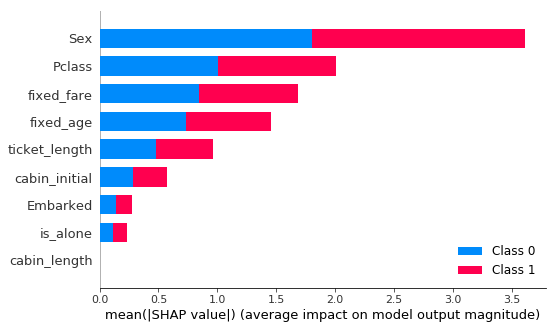

In [664]:
shap_tool.show_summary_plot()

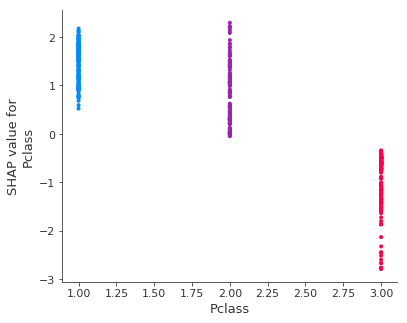

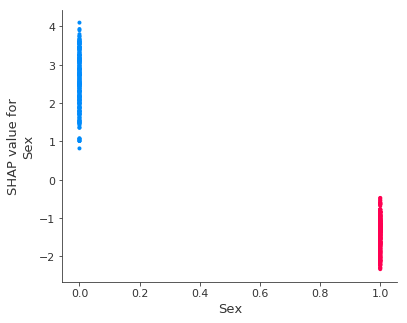

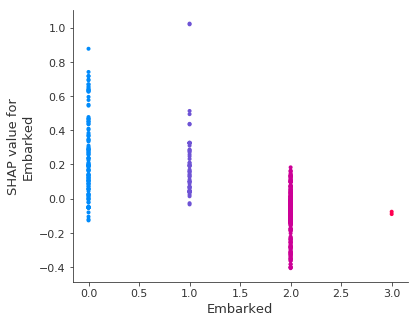

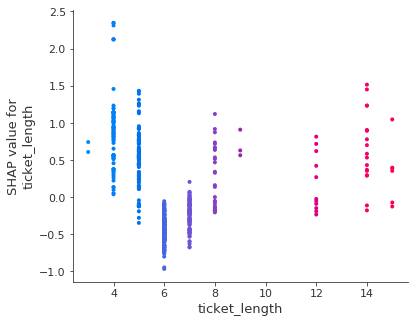

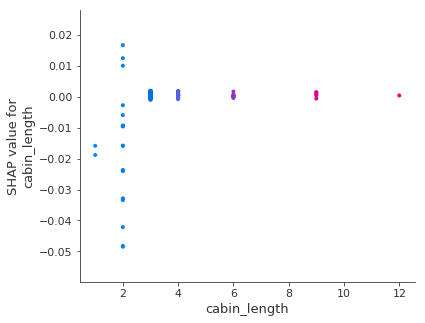

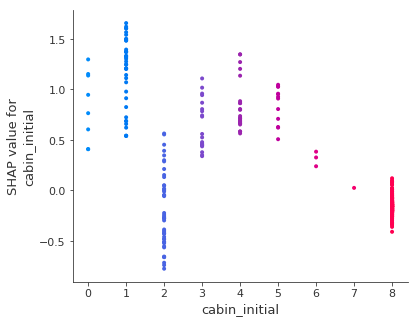

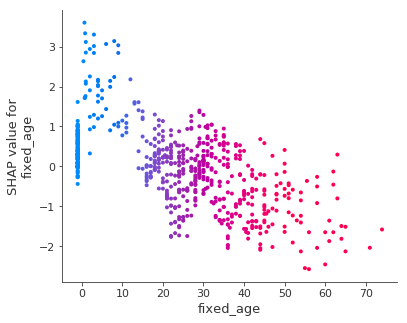

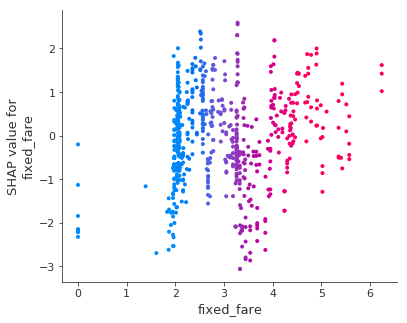

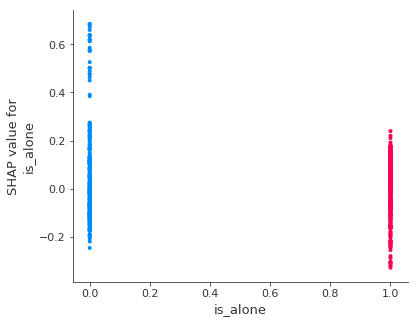

In [665]:
shap_tool.show_all_dependence_plot()